In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import optimize
from scipy.integrate import solve_ivp


In [3]:
A = np.array([[5/36, 2/9 - np.sqrt(15)/15, 5/36 - np.sqrt(15)/30],[5/36 + np.sqrt(15)/24, 2/9, 5/36 - np.sqrt(15)/24],[5/36 + np.sqrt(15)/30, 2/9 + np.sqrt(15)/15, 5/36]],dtype=float)
c= np.array([1/2 - np.sqrt(15)/10, 1/2,1/2 + np.sqrt(15)/10])
b= np.array([5/18, 4/9,5/18])
b_tilda=np.array([-5/6,8/3,-5/6])

In [4]:
def Thomas_Fermi(x,z):
    u,v=z
    return [v,np.power(u,1.5)/np.sqrt(x)]
def TF1(x,u,v):
     return v
def TF2(x,u,v):
    return np.power(u,1.5)/np.sqrt(x)

In [5]:
def Find_K(K,x_k,u_k,v_k,h):
    k1_u,k2_u,k3_u,k1_v,k2_v,k3_v=K
    eq1=k1_u-TF1(x_k+c[0]*h,u_k+h*(A[0,0]*k1_u+A[0,1]*k2_u+A[0,2]*k3_u),v_k+h*(A[0,0]*k1_v+A[0,1]*k2_v+A[0,2]*k3_v))
    eq2=k2_u-TF1(x_k+c[1]*h,u_k+h*(A[1,0]*k1_u+A[1,1]*k2_u+A[1,2]*k3_u),v_k+h*(A[1,0]*k1_v+A[1,1]*k2_v+A[1,2]*k3_v))
    eq3=k3_u-TF1(x_k+c[2]*h,u_k+h*(A[2,0]*k1_u+A[2,1]*k2_u+A[2,2]*k3_u),v_k+h*(A[2,0]*k1_v+A[2,1]*k2_v+A[2,2]*k3_v))
    eq4=k1_v-TF2(x_k+c[0]*h,u_k+h*(A[0,0]*k1_u+A[0,1]*k2_u+A[0,2]*k3_u),v_k+h*(A[0,0]*k1_v+A[0,1]*k2_v+A[0,2]*k3_v))
    eq5=k2_v-TF2(x_k+c[1]*h,u_k+h*(A[1,0]*k1_u+A[1,1]*k2_u+A[1,2]*k3_u),v_k+h*(A[1,0]*k1_v+A[1,1]*k2_v+A[1,2]*k3_v))
    eq6=k3_v-TF2(x_k+c[2]*h,u_k+h*(A[2,0]*k1_u+A[2,1]*k2_u+A[2,2]*k3_u),v_k+h*(A[2,0]*k1_v+A[2,1]*k2_v+A[2,2]*k3_v))
    return [eq1,eq2,eq3,eq4,eq5,eq6]

In [6]:
def Evaluate_K(h,K,u,v,point):
    k1u,k2u,k3u,k1v,k2v,k3v=fsolve(Find_K,K,args=(point,u,v,h))
    K=[k1u,k2u,k3u,k1v,k2v,k3v]
    return K

In [7]:
def Evaluate(K,u,v,h):
    k1u,k2u,k3u,k1v,k2v,k3v=K
    u_next=u+h*(b[0]*k1u+b[1]*k2u+b[2]*k3u)
    v_next=v+h*(b[0]*k1v+b[1]*k2v+b[2]*k3v) 
    u_tilda=u+h*(b_tilda[0]*k1u+b_tilda[1]*k2u+b_tilda[2]*k3u)
    v_tilda=v+h*(b_tilda[0]*k1v+b_tilda[1]*k2v+b_tilda[2]*k3v)
    return u_next,v_next,u_tilda,v_tilda

In [ ]:
def Step_update(u_next,v_next,u_tilda,v_tilda,h,x_old,K,sol,dist,j,X):
    step_error=np.sqrt(np.power(u_next-u_tilda,2)+np.power(v_next-v_tilda,2))
    x_curr=x_old
    n_iter=0
    n_iter1=0
    while step_error>epsilon_0 and n_iter<30:
        h=beta*h*np.power((epsilon_0/step_error),0.2)
        x_try=x_old+h
        K=Evaluate_K(h,K,sol[j-1][0],sol[j-1][1],dist[j-1])
        u_next,v_next,u_tilda,v_tilda=Evaluate(K,sol[j-1][0],sol[j-1][1],h)
        step_error=np.sqrt(np.power(u_next-u_tilda,2)+np.power(v_next-v_tilda,2))
        n_iter+= 1
    if x_old+h>X:
        h=X-x_old
        K=Evaluate_K(h,K,sol[j-1][0],sol[j-1][1],dist[j-1])
        u_next,v_next,u_tilda,v_tilda=Evaluate(K,sol[j-1][0],sol[j-1][1],h)
        x_curr=X
    else:
        x_curr=x_old+h 
    if u_next>=0:
        h_new=beta_1*h*np.power((epsilon_0/step_error),1/6)
        dist.append(x_curr)
        sol.append([u_next, v_next])
        return h_new
    else:
        while n_iter1 < 4:
            h = h / 10
            K = Evaluate_K(h, K, sol[j-1][0], sol[j-1][1], dist[j-1])
            u_next, v_next, u_tilda, v_tilda = Evaluate(K, sol[j-1][0], sol[j-1][1], h)
            if u_next >= 0:
                break
            n_iter1 += 1
        else: 
            return 0
    
        x_curr = x_old + h
        h_new = beta * h * np.power((epsilon_0 / step_error), 1/6)
        dist.append(x_curr)
        sol.append([u_next, v_next])
        return h_new

In [17]:
def RK26_implicit(initial_step,x_0,X,u_0,v_0):
    Solution=[]
    Dist=[]
    distance=[x_0]
    sol=[[u_0,v_0]]
    h=initial_step
    K=np.zeros(6)
    h_curr=h
    j=1
    x_curr=x_0
    while distance[j-1]<X:
        x_curr=distance[j-1]
        K=Evaluate_K(h_curr,K,sol[j-1][0],sol[j-1][1],distance[j-1])
        u_next,v_next,u_tilda,v_tilda=Evaluate(K,sol[j-1][0],sol[j-1][1],h_curr)
        h_curr=Step_update(u_next,v_next,u_tilda,v_tilda,h_curr,x_curr,K,sol,distance,j,X)
        if h_curr!=0:
            j+=1
        else: break
    sol=np.array(sol)
    distance=np.array(distance)
    return sol,distance

In [ ]:
X=20
x0=np.power(10.0,-235)
v_=-1.58807411
epsilon_0=np.power(10.0,-9)
beta=0.9
beta_1=0.9

In [34]:
sol,d=RK26_implicit(0.001,x_0=0,X=X,u_0=1,v_0=v_)
solve3=solve_ivp(Thomas_Fermi,[x0,X],[1,v_],method='Radau',rtol=1e-13,atol=1e-12)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_12896\4184207430.py:7: RuntimeWarning: invalid value encountered in power
  return np.power(u,1.5)/np.sqrt(x)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12896\2202337892.py:2: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  k1u,k2u,k3u,k1v,k2v,k3v=fsolve(Find_K,K,args=(point,u,v,h))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_12896\4184207430.py:3: RuntimeWarning: invalid value encountered in power
  return [v,np.power(u,1.5)/np.sqrt(x)]


In [35]:
print(f"steps made by RK6(2)={np.shape(d)[0]}")
print(f"Last node at {d[-1]}")


steps made by RK6(2)=5717
Last node at 19.72907431812709


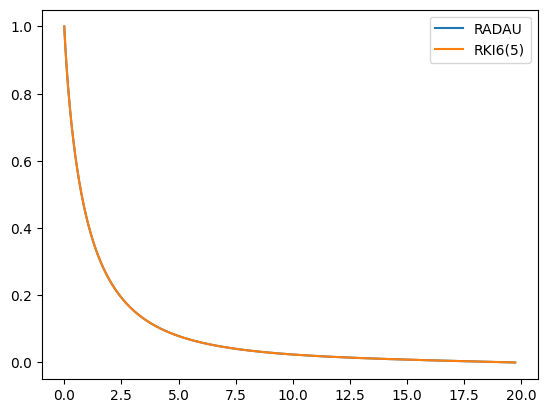

In [37]:
plt.plot(solve3.t,solve3.y[0],label='RADAU')
plt.plot(d,sol[:,0],label='RKI6(5)')
plt.legend()
plt.show()